In [1]:
import time 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.datasets import make_circles

In [2]:
# Plot defaults
plt.style.use('seaborn')

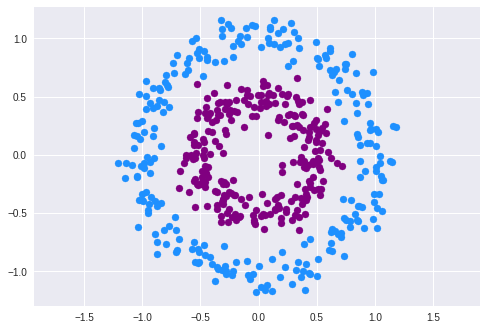

In [4]:
# Create data
X, y = make_circles(n_samples=500, noise=0.1, factor=0.5)
y = y.reshape(-1, 1)

plt.scatter(X[:, 0][y[:, 0]==0], X[:, 1][y[:, 0]==0], color='dodgerblue')
plt.scatter(X[:, 0][y[:, 0]==1], X[:, 1][y[:, 0]==1], color='purple')
plt.axis('equal')
plt.show()

## **Neural network without DL libraries**

In [5]:
# Activation function
sigmoid = (lambda x: 1 / (1 + np.e**(-x)),
           lambda x: x * (1- x))

# Cost function
l2_cost = (lambda y_predict, y_true: np.mean((y_predict - y_true)**2),
           lambda y_predict, y_true: y_predict - y_true)

In [6]:
class Layer():
    def __init__(self, in_features, out_features, act_fn):
        self.act_fn = act_fn

        # Network parameters
        self.b = np.random.rand(out_features) * 2 - 1
        self.W = np.random.rand(in_features, out_features) * 2 - 1

In [7]:
def create_nn(topology, act_fn):
    nn = []

    for l, layer in enumerate(topology[:-1]):
        nn.append(Layer(topology[l], topology[l+1], act_fn))
        
    return nn

In [8]:
def train(nn, X, Y, cost_fn, lr=0.05, train=True):
    
    # Forward pass
    out = [(None, X)]

    for l, layer in enumerate(nn):

        z = out[-1][1] @ nn[l].W + nn[l].b
        a = nn[l].act_fn[0](z)

        out.append((z, a))

    # Backpropagation
    if train:
        deltas = []

        for l in reversed(range(0, len(nn))):
            z = out[l+1][0]
            a = out[l+1][1]

            # Chain rule
            if l == len(nn) - 1:
                # Last layer
                deltas.insert(0, cost_fn[1](a, Y) * nn[l].act_fn[1](a))
            else:
                deltas.insert(0, deltas[0] @ _W.T * nn[l].act_fn[1](a))
                
            _W = nn[l].W

            # Gradient Descent
            nn[l].b = nn[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr
            nn[l].W = nn[l].W - out[l][1].T @ deltas[0] * lr
     
    return out[-1][1]

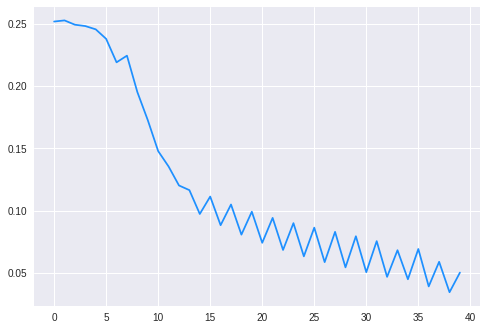

In [9]:
topology = [2, 4, 8, 1]

nn = create_nn(topology, sigmoid)
loss = []

# Train
for i in range(1000):
    y_predict = train(nn, X, y, l2_cost)
    
    if i % 25 == 0:
        loss.append(l2_cost[0](y_predict, y))

        plt.plot(range(len(loss)), loss, color='dodgerblue')
        plt.show()

        clear_output(wait=True)
        time.sleep(0.5)

## **Neural Netword with pytorch**


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from sklearn.model_selection import train_test_split

device = torch.device('cuda')

In [11]:
# Split data
x_train, x_val , y_train, y_val = train_test_split(X, y, test_size=0.20)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(in_features=2, out_features=4)
        self.fc2 = nn.Linear(in_features=4, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=2)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

For the special binary classification case, using two values in the last layer output is redundant, since one is always 1 minus the other. Log_softmax in combination with negative log likelihood loss function (NLLLOSS) is equivalent to the binary cross-entropy.

In [13]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.long)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [14]:
# Trainloader
trainset = dataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=128,shuffle=False)

In [15]:
# Valloader
valset = dataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=128)

In [16]:
dataloaders = {
    'train': trainloader,
    'val': valloader
}

In [17]:
# Metrics for loss and accuracy
class RunningMetrics():
    def __init__(self):
        self.S = 0
        self.N = 0 

    def update(self, value, size):
        self.S += value
        self.N += size

    def __call__(self):
        return self.S / float(self.N)

In [18]:
def train(model, optimizer, loss_fn, dataloaders, num_epochs):

    losses_train = []
    losses_val = []

    for epoch in range(num_epochs):   
        running_loss_train = RunningMetrics()
        running_loss_val = RunningMetrics()
        running_acc = RunningMetrics() 
        
        for phase in ['train', 'val']:
            for inputs, targets in dataloaders[phase]:
                optimizer.zero_grad() # set the gradients to zero
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                _, preds = torch.max(outputs, 1)
                batch_size = outputs.shape[0]

                with torch.set_grad_enabled(phase=='train'):

                    loss = loss_fn(outputs, targets[:, 0])
                    if phase == 'train':
                        loss.backward() # gradient computation
                        optimizer.step() # update parameters
                        
                        # Update metrics
                        running_loss_train.update(loss.item()*batch_size, batch_size)

                    else:
                        running_loss_val.update(loss.item()*batch_size, batch_size) 
                        running_acc.update(torch.sum(preds == targets[:, 0]), batch_size)

        # Plot
        if epoch % 25 == 0:
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss_train(), 
                                                    running_acc()))

            losses_train.append(running_loss_train())
            losses_val.append(running_loss_val())

            plt.plot(range(len(losses_train)), losses_train, color='dodgerblue')
            plt.plot(range(len(losses_val)), losses_val, color='purple')
            
            plt.show()

            clear_output(wait=True)
            time.sleep(0.5)

In [19]:
# Hyper parameters
learning_rate = 0.01

# Model, Optimizer, Loss
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

Epoch 1001/1001
Loss: 0.0031 Acc: 0.9900


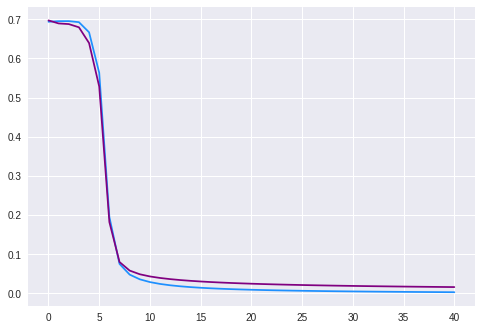

In [20]:
train(model, optimizer, loss_fn, dataloaders, num_epochs=1001)

## **Model visualization**

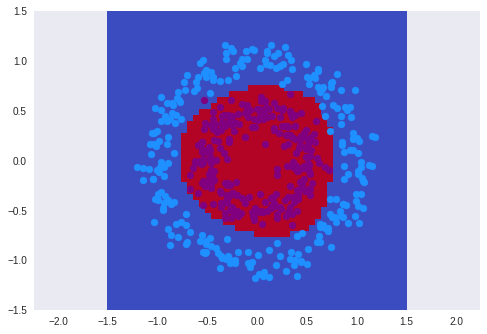

In [21]:
res = 50 

_x0 = np.linspace(-1.5, 1.5, res).astype(np.float32)
_x1 = np.linspace(-1.5, 1.5, res).astype(np.float32)

_y = np.zeros((res, res))

for i0, x0 in enumerate(_x0):
    for i1, x1 in enumerate(_x1):
        output = model(torch.tensor([[x0, x1]]).to(device))
        _, pred = torch.max(output, 1)
        _y[i0, i1] = pred.cpu().detach().numpy()

plt.pcolormesh(_x0, _x1, _y, cmap='coolwarm')
plt.scatter(X[:, 0][y[:, 0]==0], X[:, 1][y[:, 0]==0], color='dodgerblue')
plt.scatter(X[:, 0][y[:, 0]==1], X[:, 1][y[:, 0]==1], color='purple')
plt.axis('equal')
plt.show()